In [1]:
%pylab inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
import numpy as np

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/tw/zmm3b0k97wbfj0cl53y3w2nm0000gn/T/ipykernel_90335/395611636.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [96]:
load_file=np.loadtxt('input.txt')
results_foldername='results_Mpl'+str(load_file[0])+'_CMF'+str(load_file[1])+'_time'+str(load_file[2])+'_Qrad'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_Teq'+str(load_file[8])


In [144]:
CMF_list=np.linspace(0.1*100.0,0.8*100.0,8)
Mpl_list=np.zeros(11)
Mpl_list[0]=1.0
Mpl_list[1]=1.25
Mpl_list[2]=1.5
Mpl_list[3]=2.0
Mpl_list[4]=2.5
Mpl_list[5]=3.0
Mpl_list[6]=4.0
Mpl_list[7]=5.0
Mpl_list[8]=6.0
Mpl_list[9]=7.0
Mpl_list[10]=8.0
foldername=[]
for i in range(len(Mpl_list)):
    foldername_CMF=[]
    if Mpl_list[i]%1.0==0.0:
        Mpl_part=str(int(Mpl_list[i]))+'ME_'
    elif Mpl_list[i]%1.0==0.5:
        Mpl_part=str(int(Mpl_list[i]))+'hME_'
    else:
        Mpl_part=str(int(Mpl_list[i]))+'Q1ME_'
    print(Mpl_part)
    for j in range(len(CMF_list)):
        foldername_CMF.append(Mpl_part+str(int(CMF_list[j]))+'CMF/')
    foldername.append(foldername_CMF)
foldername[0][-1]='1ME_75CMF/'

1ME_
1Q1ME_
1hME_
2ME_
2hME_
3ME_
4ME_
5ME_
6ME_
7ME_
8ME_


In [145]:
dir_path='../../Exoplanet_magnetic_field/Paper2_v1/'
Pc=np.zeros((len(Mpl_list),len(CMF_list)))
Tc=np.zeros((len(Mpl_list),len(CMF_list)))
i=int(0)
j=int(0)
for i in range(len(Mpl_list)):
    for j in range(len(CMF_list)):
        load_file=np.loadtxt(dir_path+foldername[i][j]+'henyey0.txt')
        Pc[i][j]=load_file[:,1][0]+50e9
        load_file=np.loadtxt(dir_path+foldername[i][j]+'structure0.txt')
        Tc[i][j]=load_file[:,0][0]

In [153]:
np.savetxt('EoS/Guess_initial/Pc.txt',Pc)

In [157]:
np.savetxt('EoS/Guess_initial/Mpl_grid.txt',np.transpose([CMF_list]))

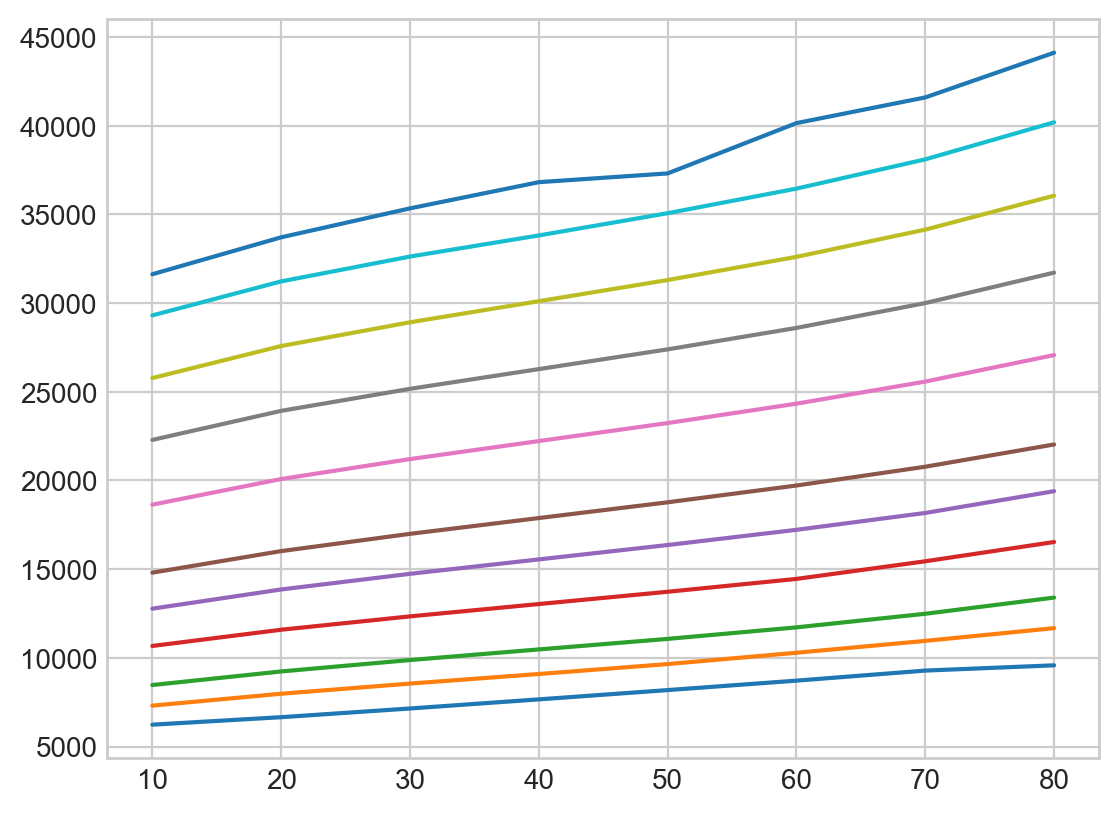

In [154]:
for i in range(len(Tc)):
    plot(CMF_list,Tc[i])

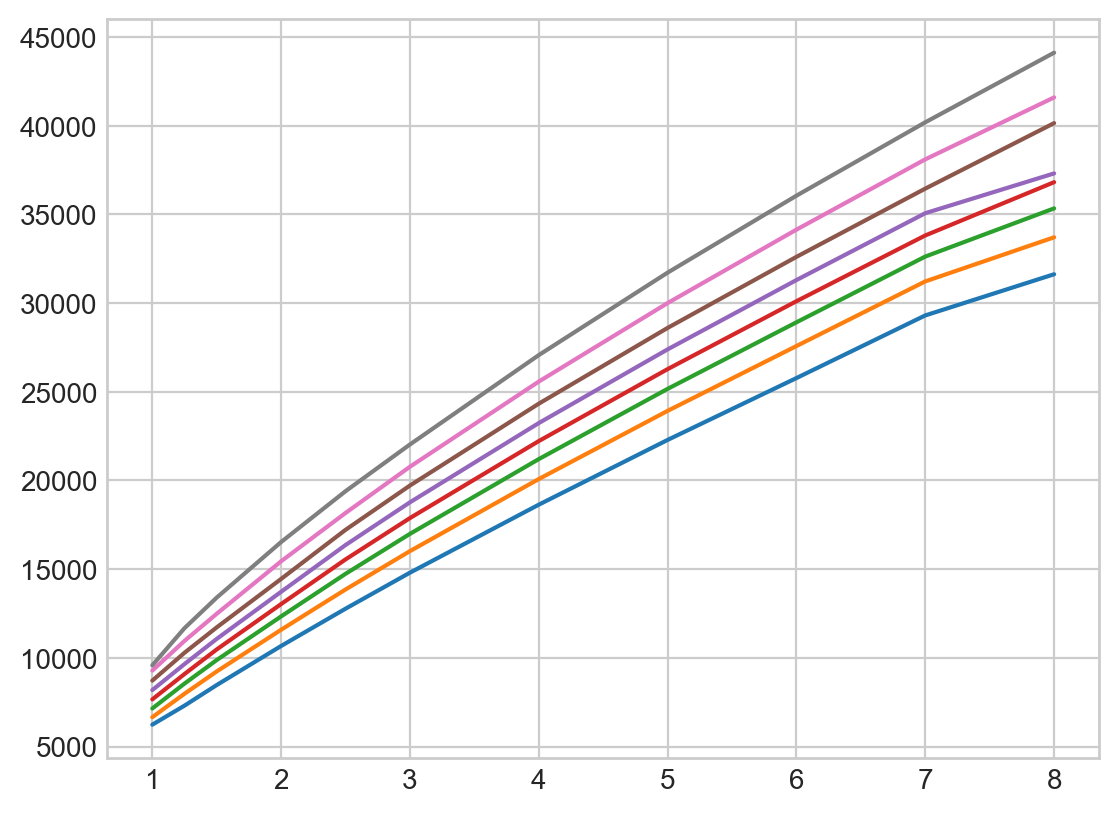

In [155]:
for i in range(len(Tc[0])):
    plot(Mpl_list,Tc[:,i])

In [234]:
load_file=np.loadtxt('input.txt') # read in input files.
results_foldername='results_Mass'+str(load_file[0])+'EarthMass_CoreMassFraction'+str(load_file[1])+'_TotalTime'+str(load_file[2])+'Gyr_RadiogenicHeatingKThU238U235RatioToEarth'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_EquilibriumTemperature'+str(load_file[8])+'K'


new_h=np.loadtxt('results_Mpl1.5_CMF0.326_time12.0_Qrad1.0_1.0_1.0_1.0_Teq255.0/profile/t0/henyey0.txt')
new_s=np.loadtxt('results_Mpl1.5_CMF0.326_time12.0_Qrad1.0_1.0_1.0_1.0_Teq255.0/profile/t0/structure0.txt')
old_h=np.loadtxt(results_foldername+'/profile/t0/old/henyey0.txt')
old_s=np.loadtxt(results_foldername+'/profile/t0/old/structure0.txt')
old_Fe=np.loadtxt(results_foldername+'/profile/t0/old/Fe_melt.txt')
new_Fe=np.loadtxt('results_Mpl1.5_CMF0.326_time12.0_Qrad1.0_1.0_1.0_1.0_Teq255.0/profile/t0/Fe_melt.txt')


In [249]:
load_file=np.loadtxt('input.txt')
results_foldername='results_Mpl'+str(load_file[0])+'_CMF'+str(load_file[1])+'_time'+str(load_file[2])+'_Qrad'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_Teq'+str(load_file[8])

evo=np.loadtxt(results_foldername+'/evolution.txt')

In [246]:
evo_0=np.loadtxt('results_Mass1.5EarthMass_CoreMassFraction0.326_TotalTime12.0Gyr_RadiogenicHeatingKThU238U235RatioToEarth1.0_1.0_1.0_1.0_EquilibriumTemperature255.0K/evolution.txt')

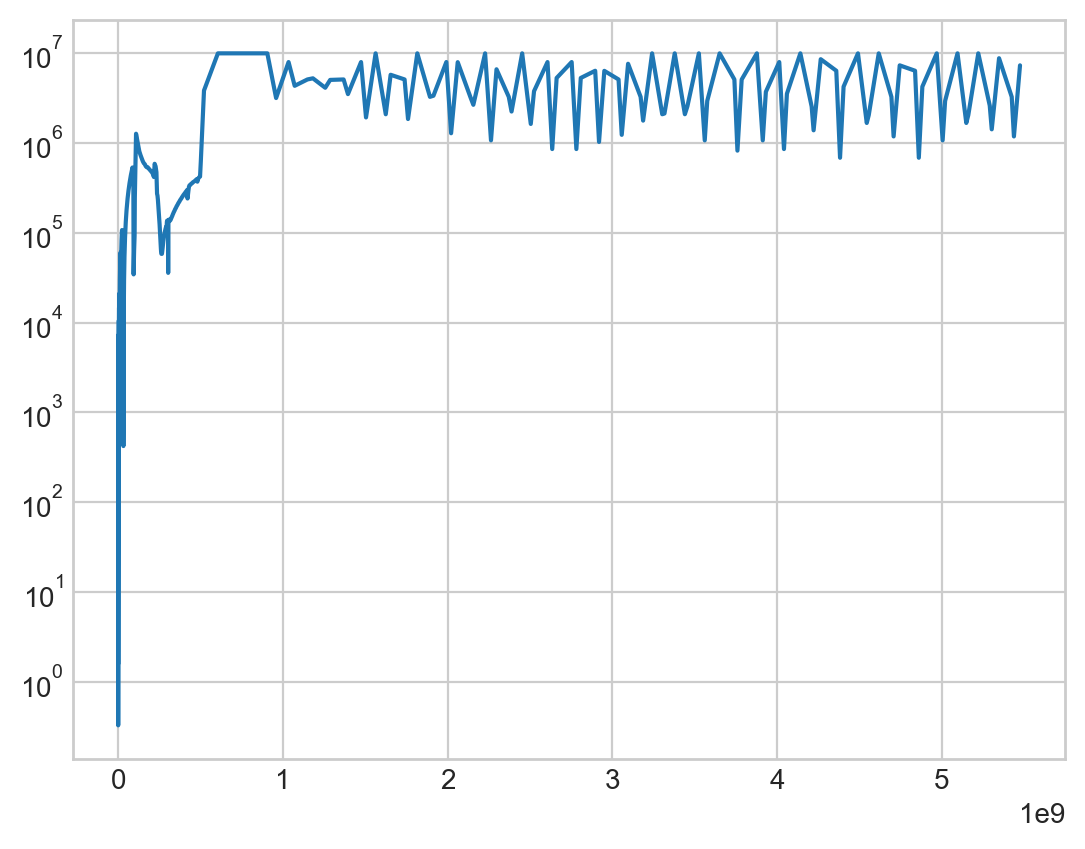

In [248]:
plt.yscale('log')
plot(evo[:,0]/86400.0/365.0,evo[:,1]/86400.0/365.0)
#plot(evo_0[:,0]/86400.0/365.0,evo_0[:,1])

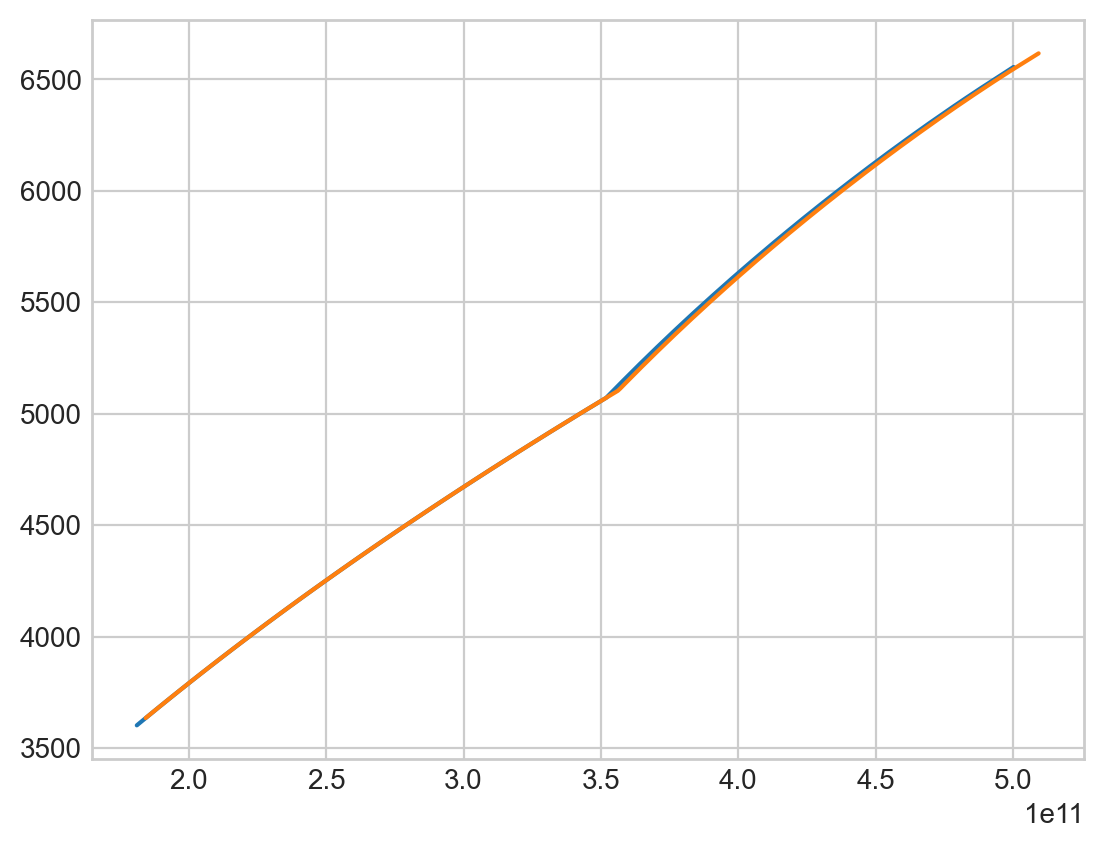

In [236]:
plot(new_Fe[:,0],new_Fe[:,1])
plot(old_Fe[:,0],old_Fe[:,1])

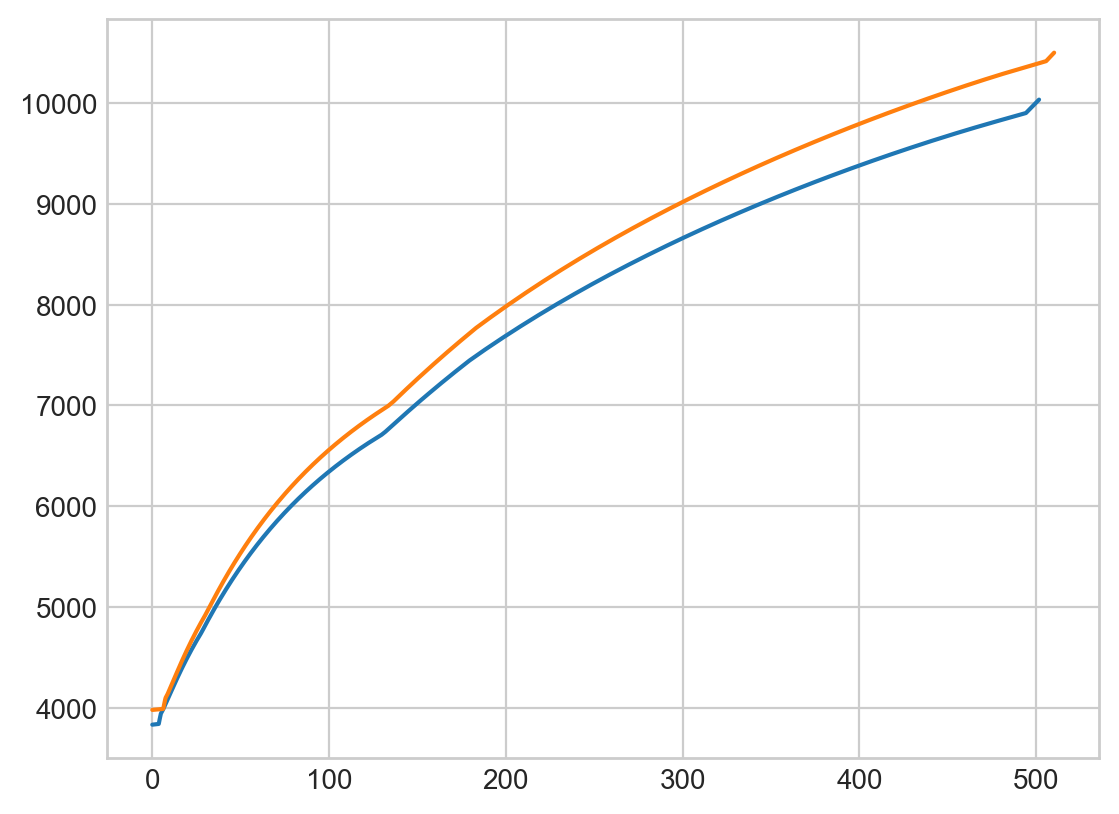

In [233]:
plot(new_h[:,1]/1e9,new_s[:,0])
plot(old_h[:,1]/1e9,old_s[:,0])

In [253]:
dir_path1='results_Mpl1.5_CMF0.326_time12.0_Qrad1.0_1.0_1.0_1.0_Teq255.0'
dir_path2='results_Mass1.5EarthMass_CoreMassFraction0.326_TotalTime12.0Gyr_RadiogenicHeatingKThU238U235RatioToEarth1.0_1.0_1.0_1.0_EquilibriumTemperature255.0K'

trial1=np.loadtxt(dir_path1+'/profile/StructureProfile_1018102919.txt')
trial2=np.loadtxt(dir_path2+'/profile/StructureProfile_1010049633.txt')

In [257]:
load_file=np.loadtxt('input.txt')
results_foldername='results_Mpl'+str(load_file[0])+'_CMF'+str(load_file[1])+'_time'+str(load_file[2])+'_Qrad'+str(load_file[3])+'_'+str(load_file[4])+'_'+str(load_file[5])+'_'+str(load_file[6])+'_Teq'+str(load_file[8])
save_t=[1.0]
for i in range(1,247):
    if save_t[i-1]<5000.0:
        save_t.append(save_t[i-1]+80.0)
    elif save_t[i-1]<1e8:
        save_t.append(save_t[i-1]+int(save_t[i-1]/6.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/25.0))


In [261]:
for i in range(len(save_t)):
    
        s=np.loadtxt(results_foldername+'/profile/StructureProfile_'+str(int(save_t[i]))+'.txt')
        print(i,max(s[:,7]/(4.0*np.pi*s[:,0]**2.0)))

0 2143496.262271683
1 714976.1141489296
2 682167.821533108
3 651827.5291808884
4 623937.5070724813
5 598815.7113384857
6 574915.6955006308
7 553453.0680939219
8 533736.1941232295
9 515868.3800981436
10 499421.7881684349
11 483188.63918217097
12 467323.56603057444
13 453789.2756460453
14 439767.727328798
15 426739.0888807701
16 414666.1926975247
17 401640.3940209953
18 387441.70990234334
19 374529.191014782
20 361523.246512905
21 350927.74906671105
22 340538.4651432098
23 330238.9553691157
24 319866.4455442648
25 311442.5279163459
26 302869.5868233706
27 294228.7544799631
28 285476.6848010418
29 276427.1079932503
30 266845.27438666776
31 258923.66203080426
32 247436.49584703325
33 237900.41464935342
34 227342.63045495795
35 215697.76459139283
36 202132.47420957277
37 185466.15571967245
38 187065.92300105348
39 643788.8290015789
40 17424.866363414178
41 14396.81283167465
42 12782.161488633801
43 11662.826753297066
44 10770.869594613443
45 10038.29365756973
46 9465.310346271846
47 8936.81

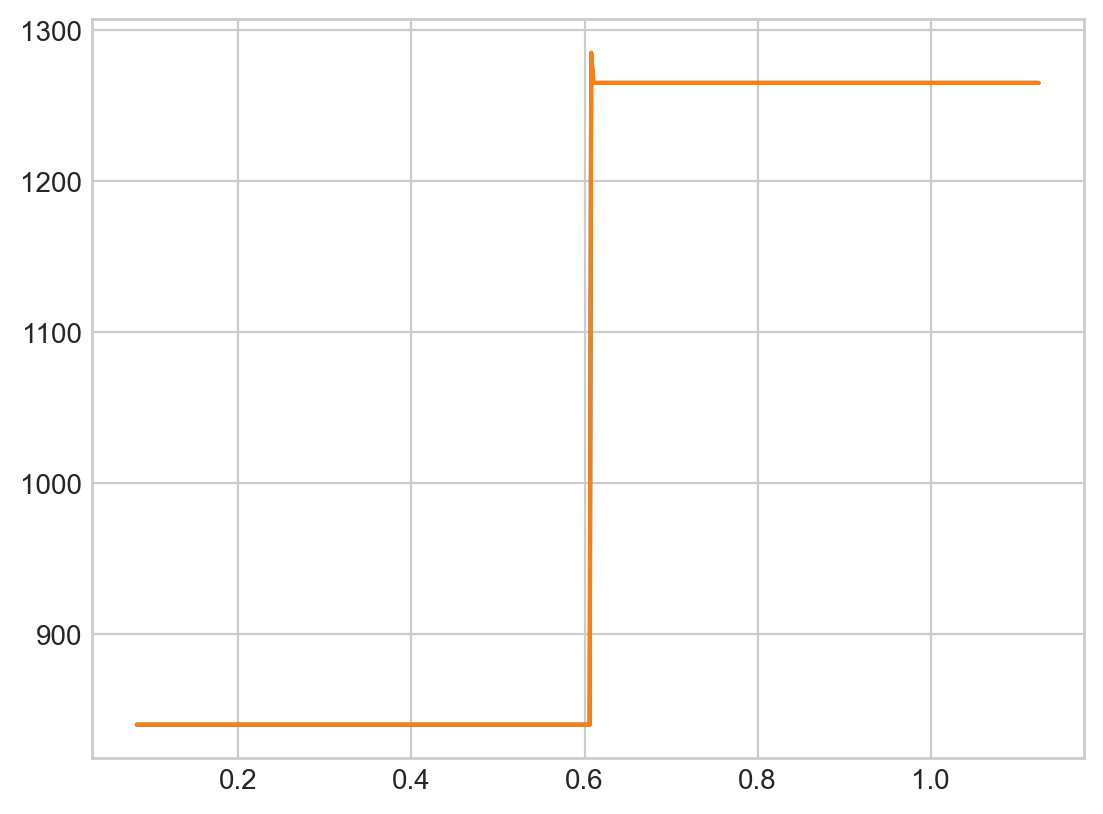

In [256]:
plot(trial1[:,0]/6371000.0,trial1[:,6])
plot(trial2[:,0]/6371000.0,trial2[:,6])

In [252]:
import matplotlib.style as mplstyle
import time

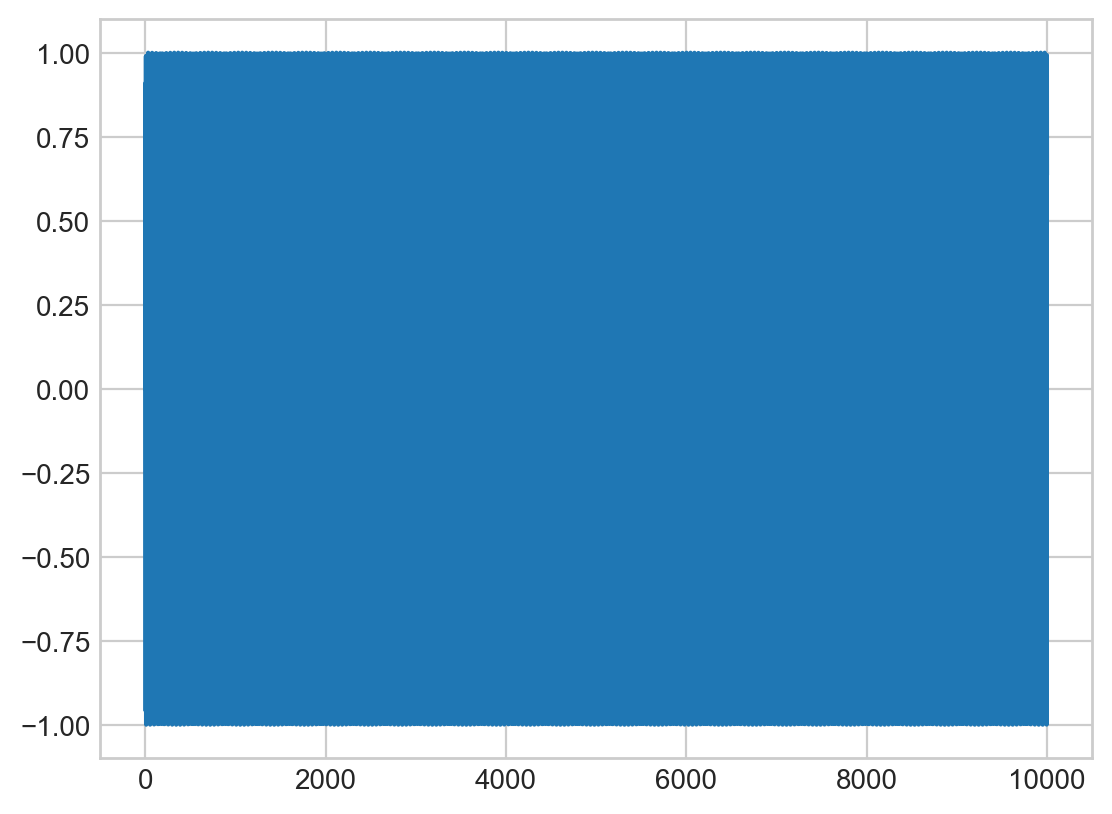

In [250]:
x = np.arange(0, 10000, 1)
y = np.sin(x)

while i
# Plot the data
plt.plot(x, y)


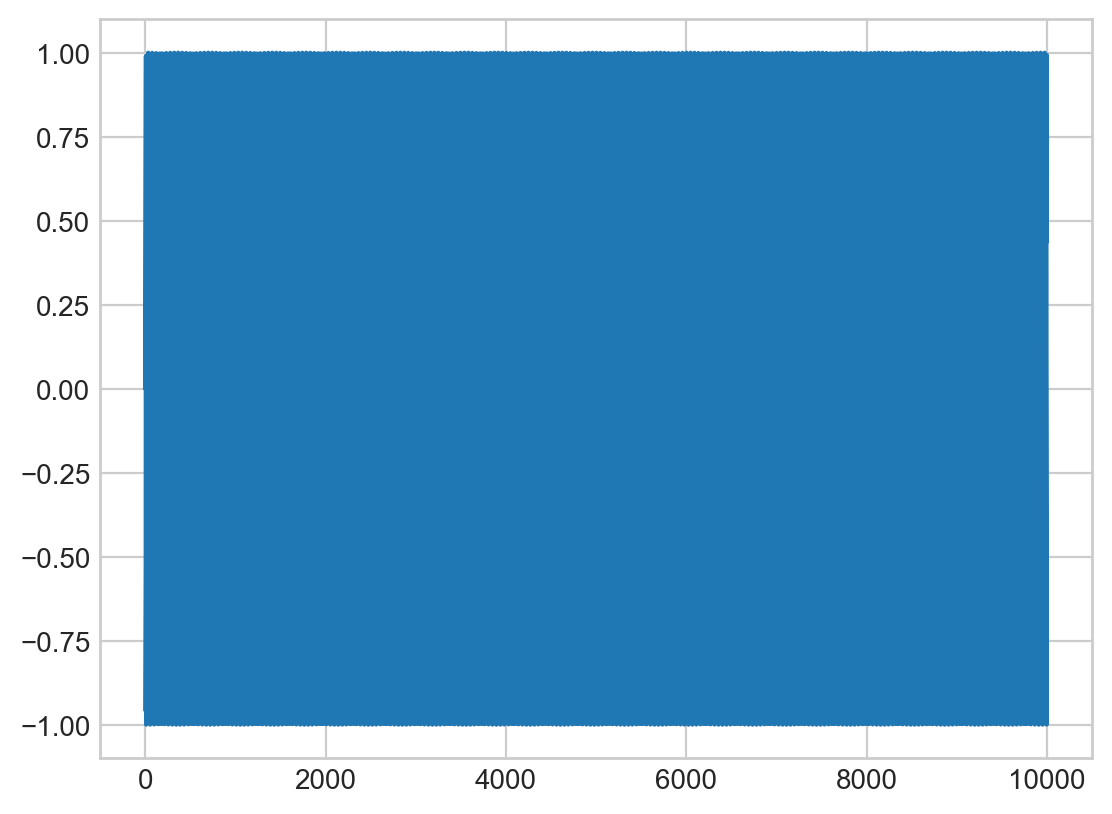

In [251]:
mplstyle.use('fast')
plt.plot(x, y)

In [4]:
evo=np.loadtxt('results/evolution.txt')
# index  variable  #### everything is in SI units
# 0       t
# 1       dt
# 2       average mantle specific entropy
# 3       average mantle temperature
# 4       average core temperature 
# 5       surface temperature
# 6       core mantle boundary (CMB) temperature
# 7       surface heat flux
# 8       CMB flux
# 9       Conductive flux along core adiabat (threshold flux for thermal convection in liquid core)
# 10      Planet radius
# 11      Core radius
# 12      Central pressure
# 13      CMB pressure

## pick values for i_x and i_y in the following boxes to set x and y-axis to plot thermal history of the planet

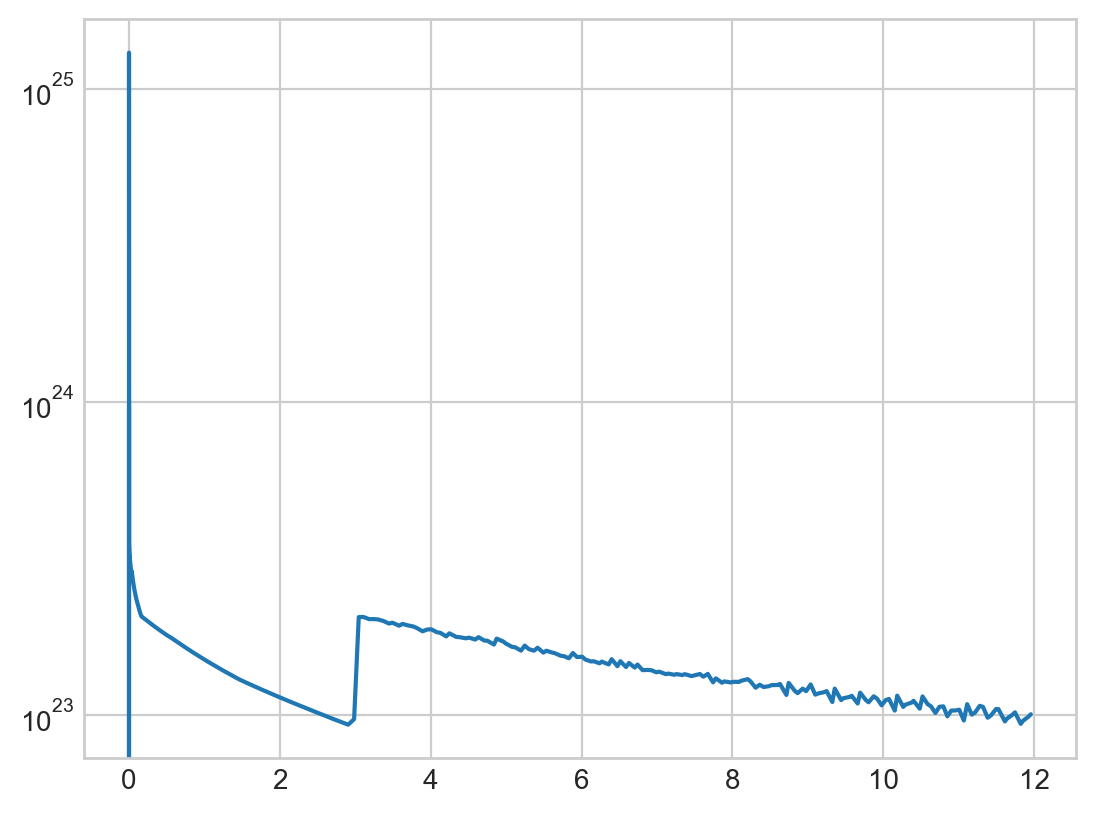

In [6]:
i_x=0
i_y=-1
plt.yscale('log')
plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y])

Text(0.5, 0, 'Gyr')

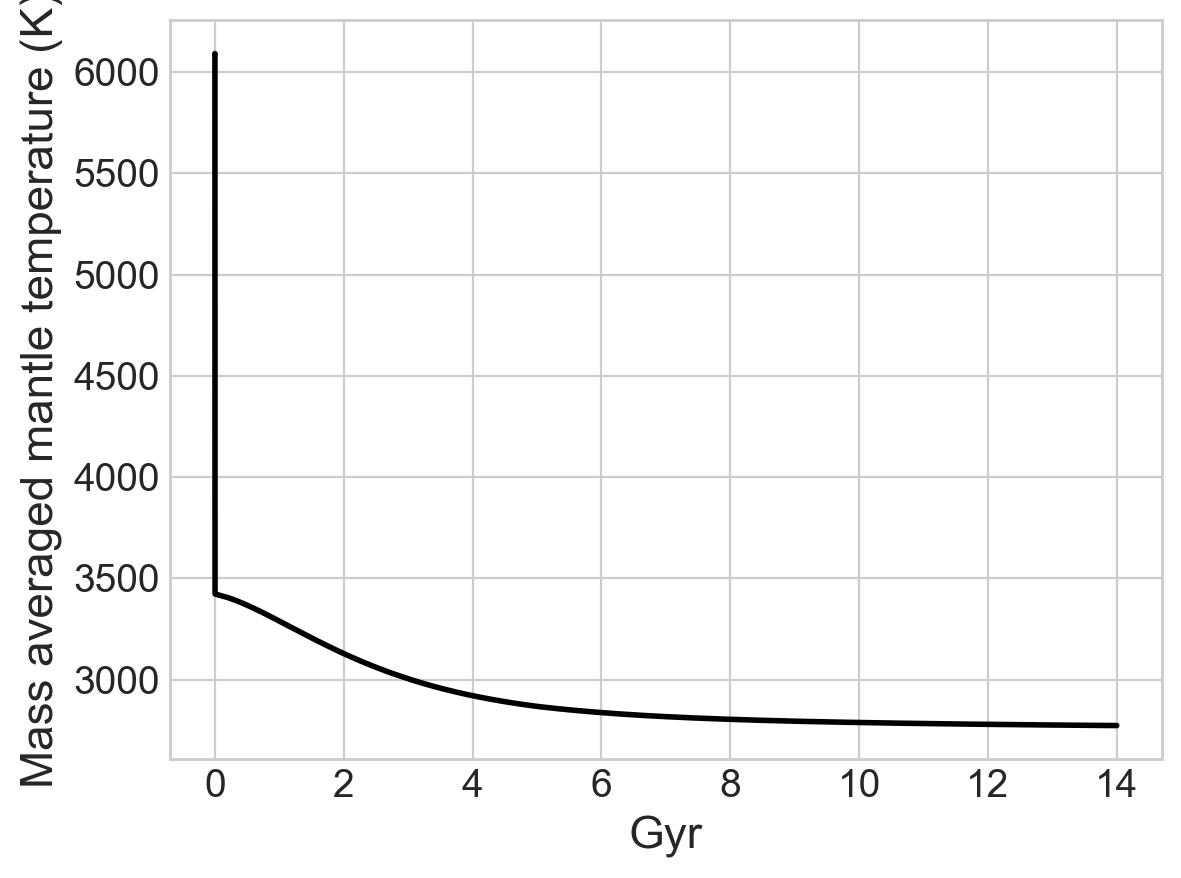

In [6]:
i_x=0
i_y=3
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged mantle temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

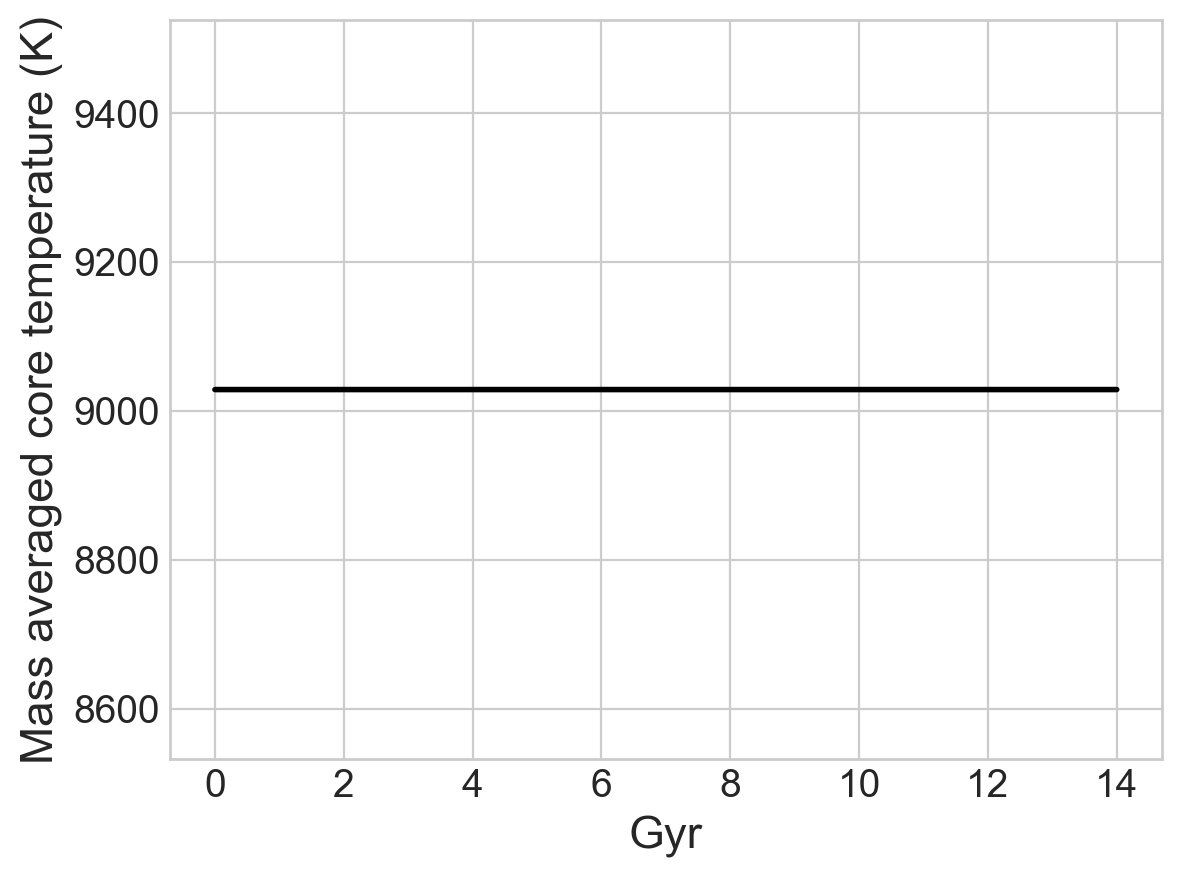

In [7]:
i_x=0
i_y=4
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mass averaged core temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

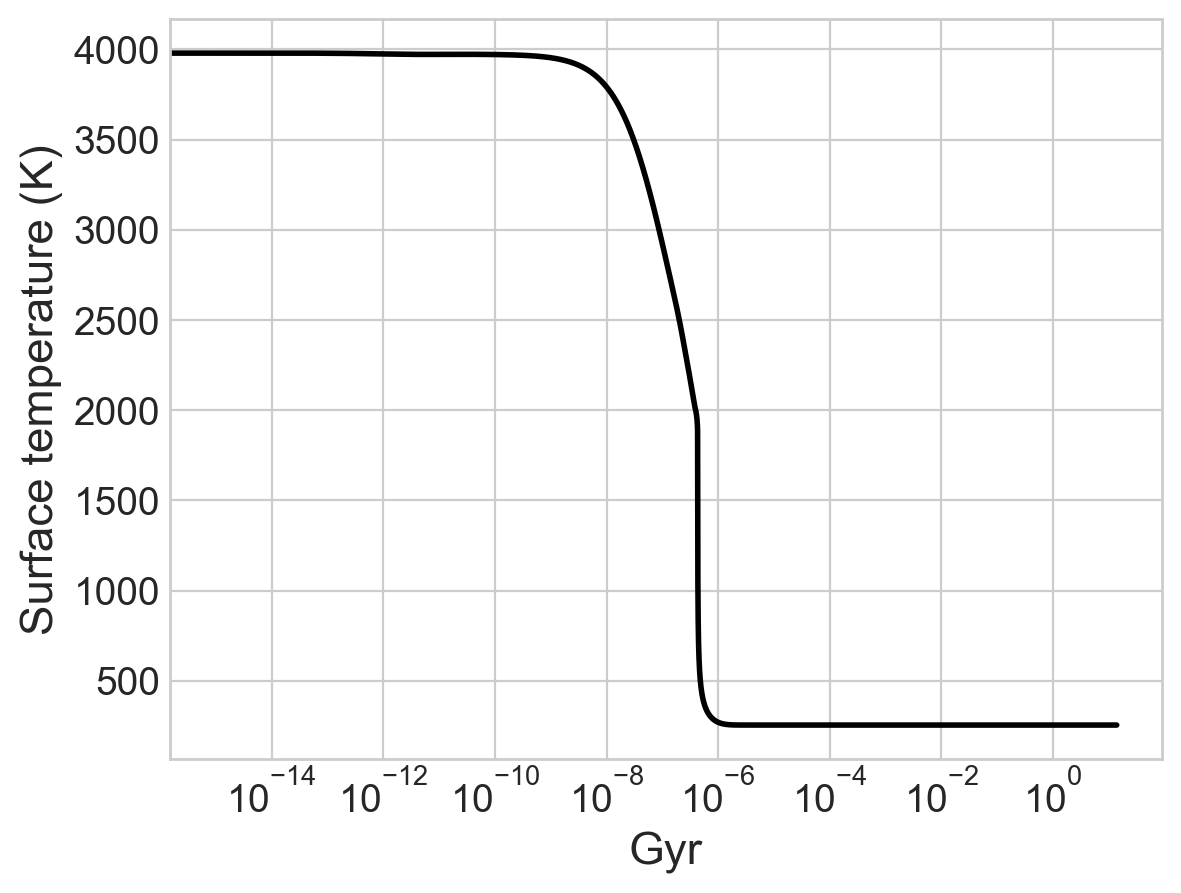

In [48]:
i_x=0
i_y=5
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface temperature (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

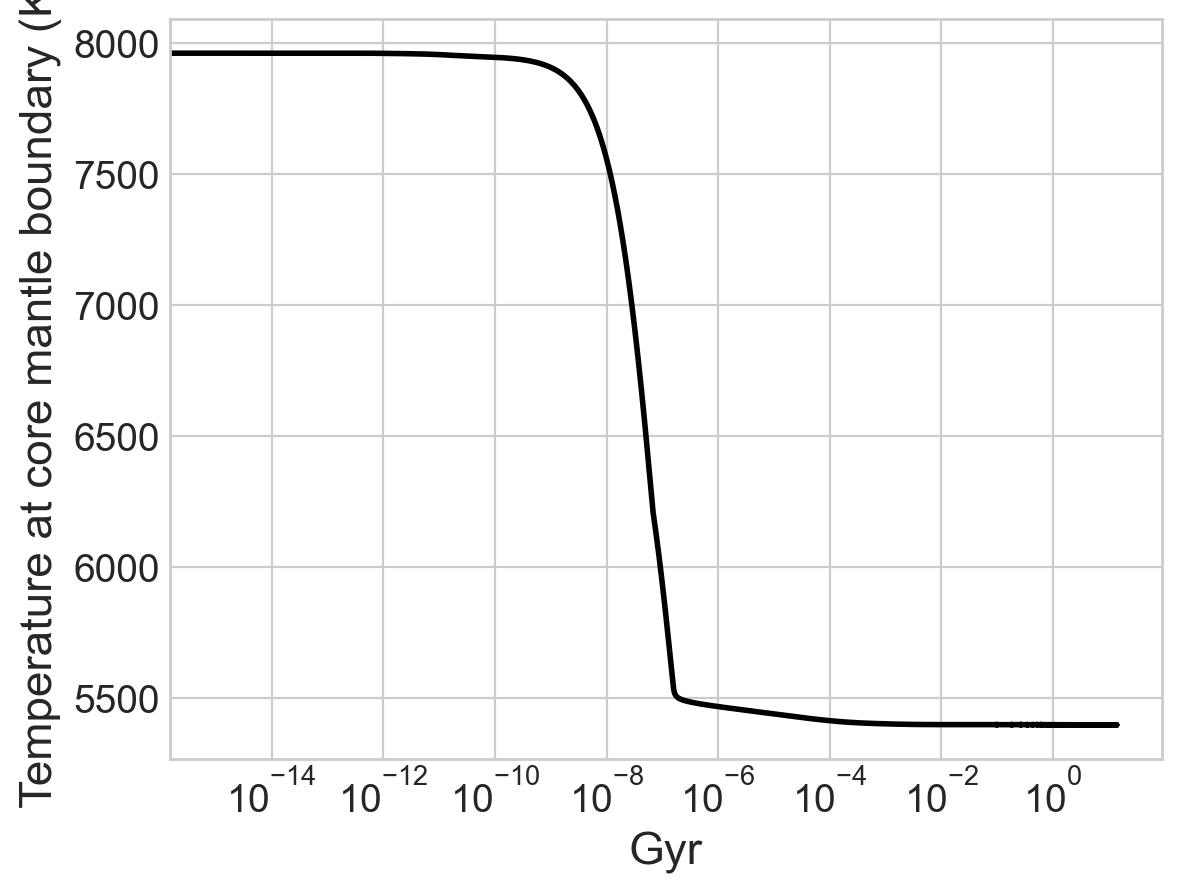

In [12]:
i_x=0
i_y=6
plt.xscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Temperature at core mantle boundary (K)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

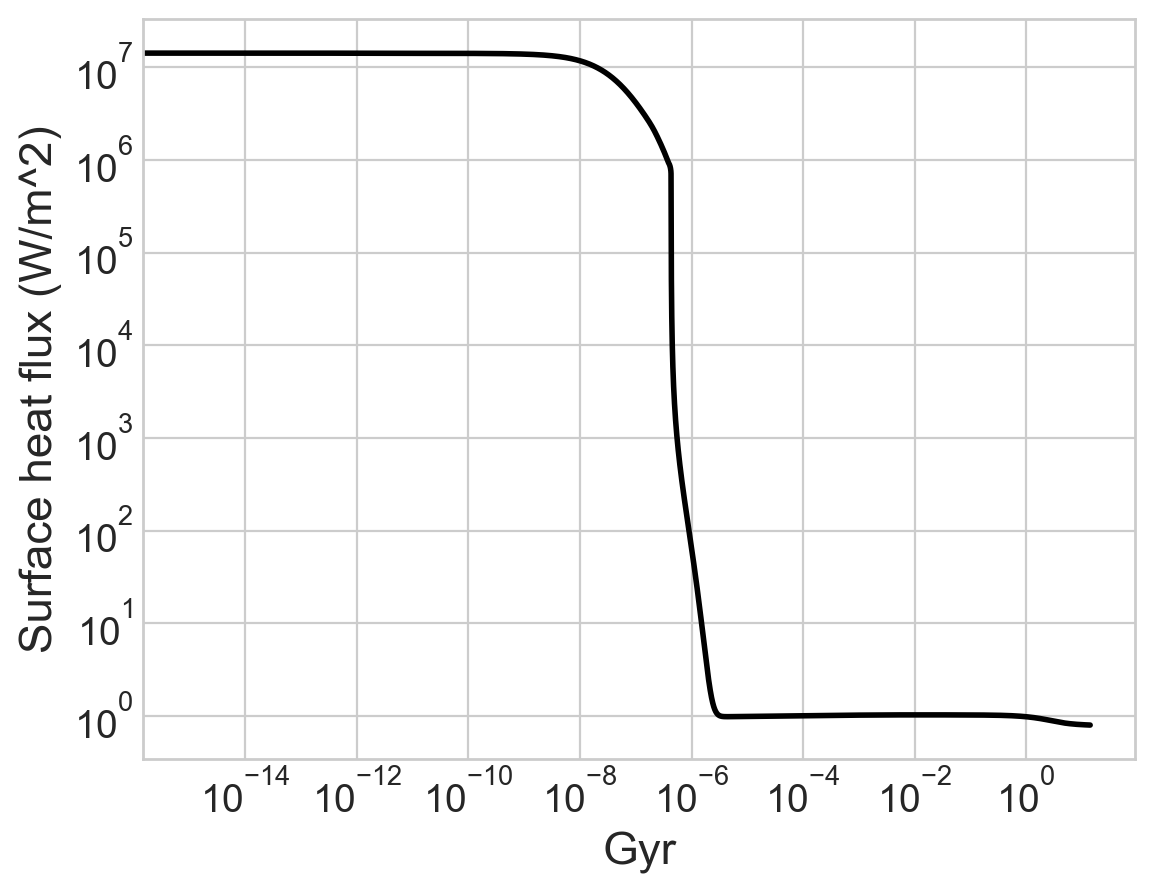

In [16]:
i_x=0
i_y=7
plt.xscale('log')
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Surface heat flux (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

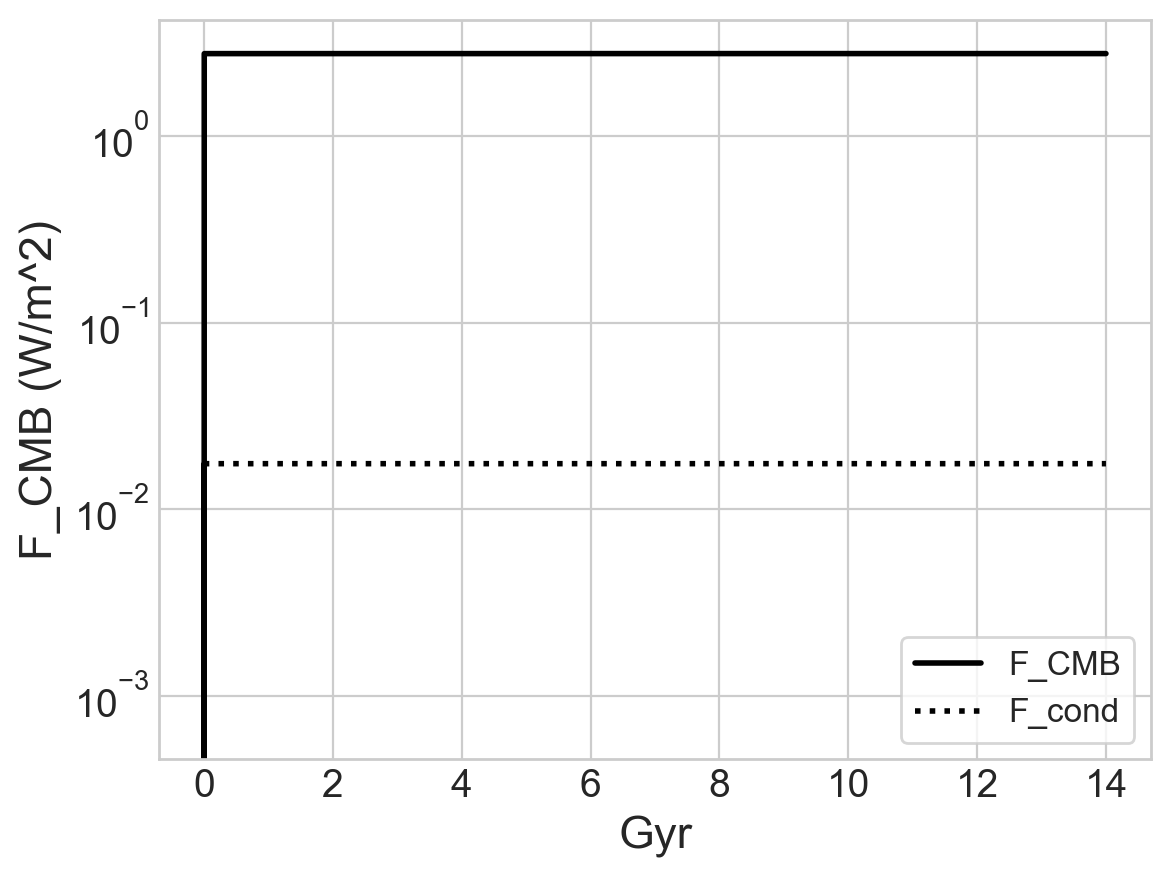

In [19]:
i_x=0
i_y=8
plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,label='F_CMB')
i_y=9
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y],color='black',linewidth=2.0,linestyle=':',label='F_cond')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('F_CMB (W/m^2)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 
plt.legend(frameon=True, fontsize=12)

Text(0.5, 0, 'Gyr')

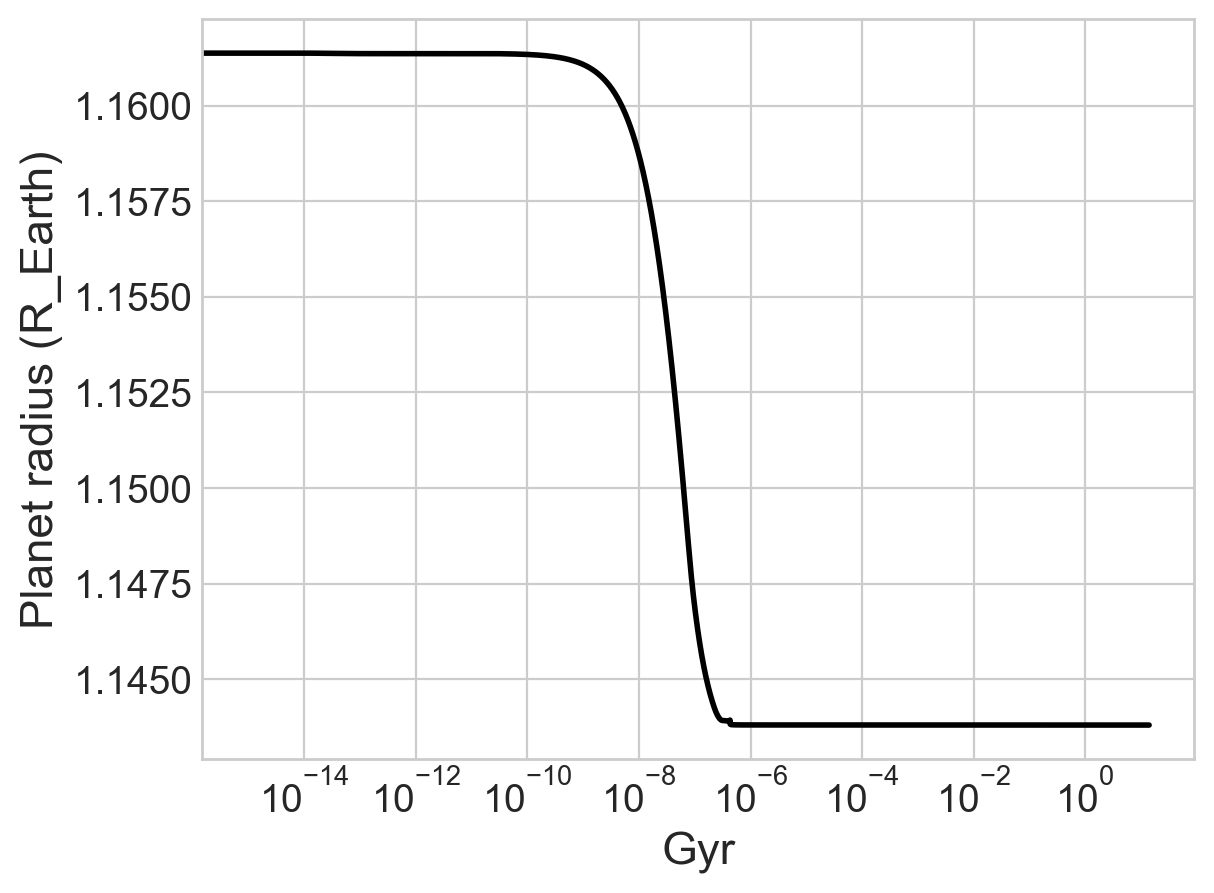

In [21]:
i_x=0
i_y=10
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Planet radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

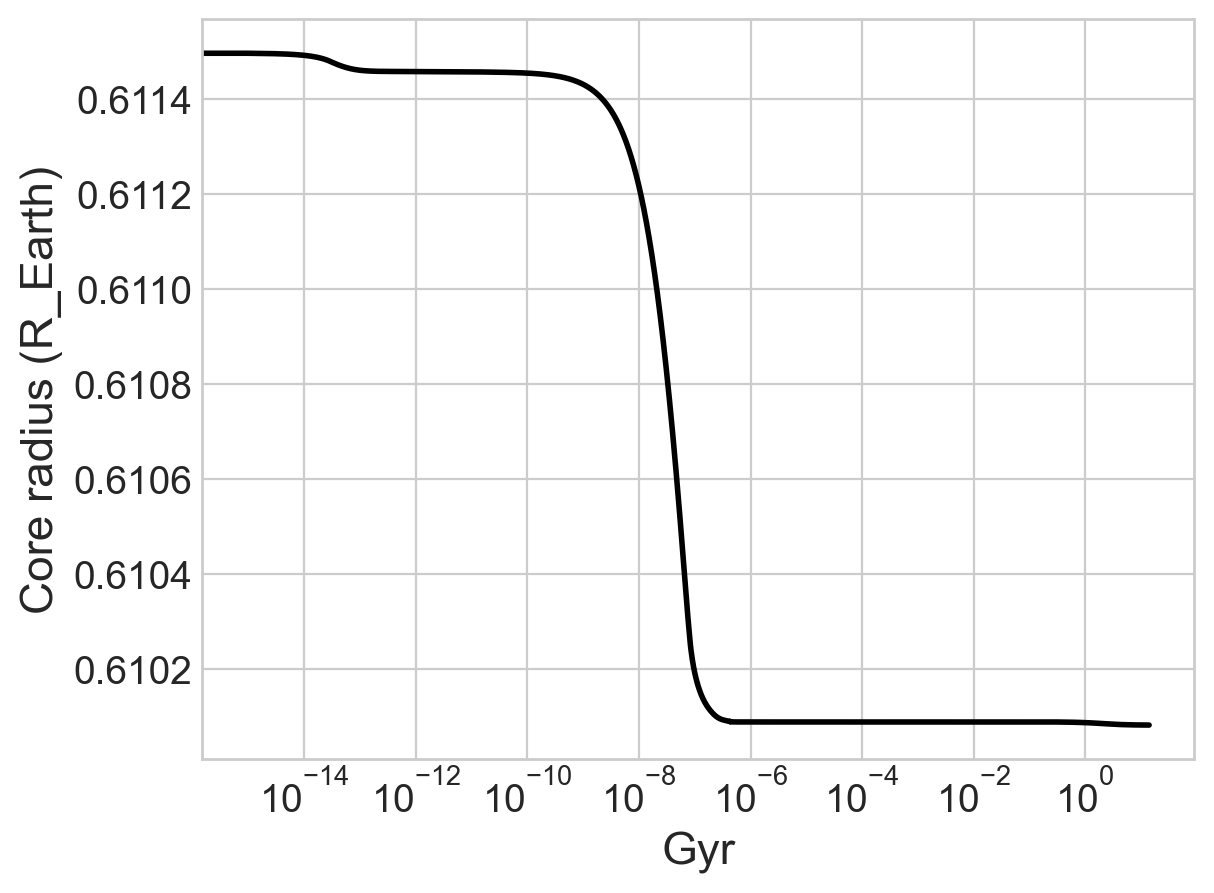

In [22]:
i_x=0
i_y=11
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/6371000.0,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Core radius (R_Earth)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

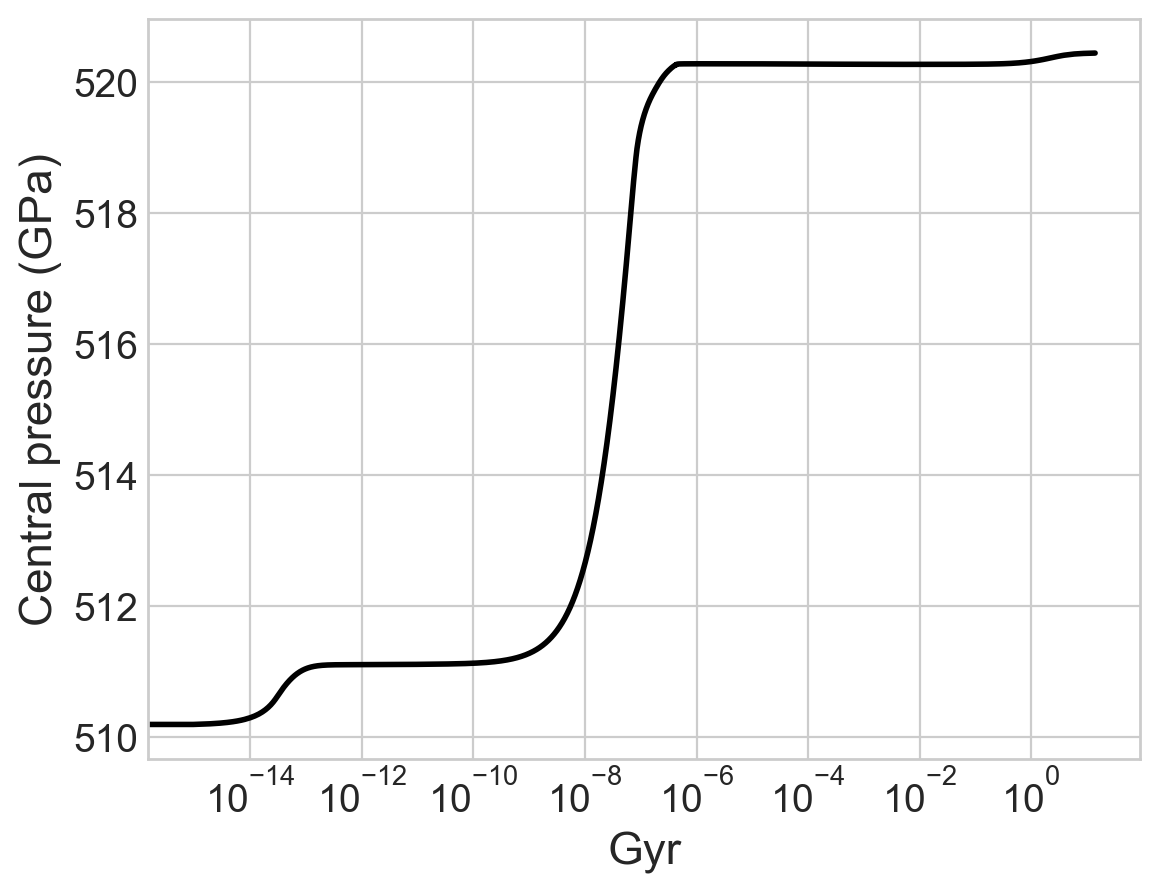

In [23]:
i_x=0
i_y=12
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Central pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

Text(0.5, 0, 'Gyr')

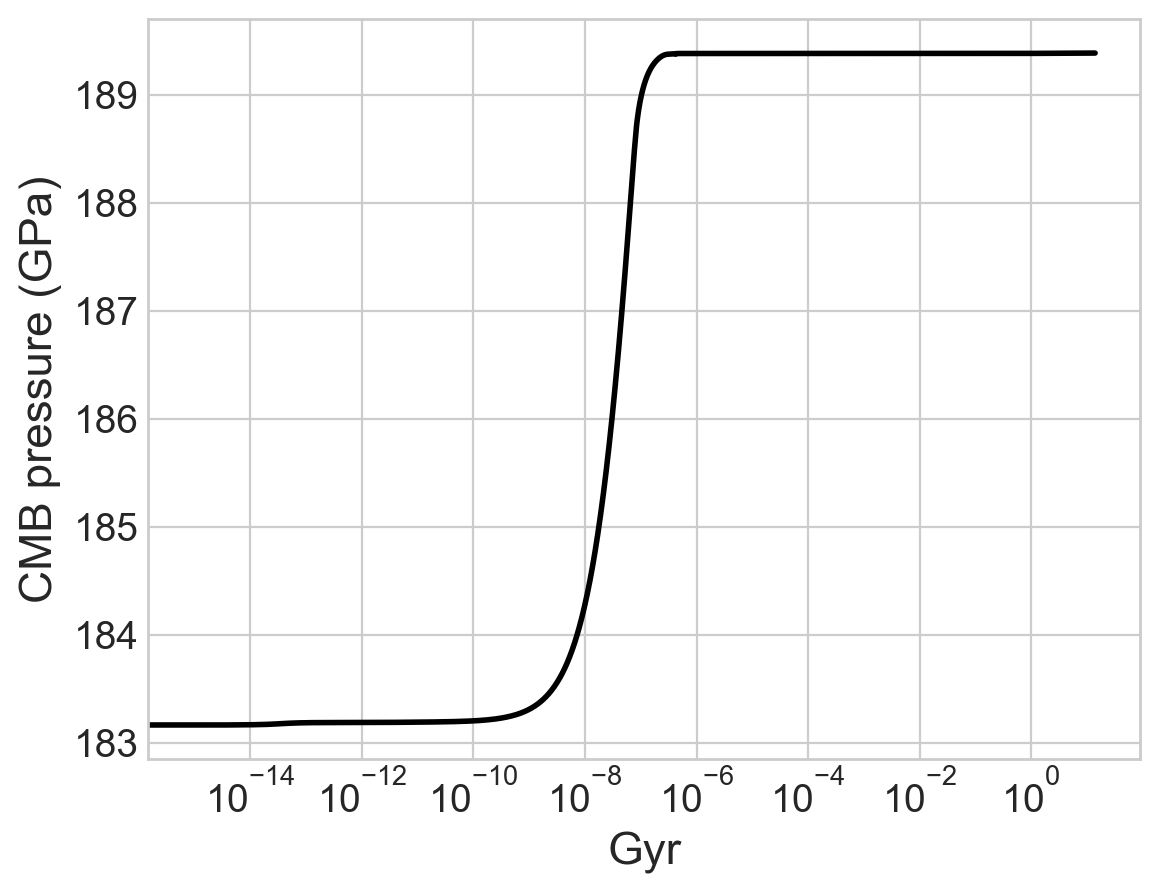

In [24]:
i_x=0
i_y=13
plt.xscale('log')
#plt.yscale('log')
plt.plot(evo[:,i_x]/1e9/86400.0/365.0,evo[:,i_y]/1e9,color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 

In [25]:
# timesteps (years) for which profiles are saved

save_t=[1.0]
for i in range(1,1000):
    if save_t[i-1]<10000.0:
        save_t.append(save_t[i-1]+20.0)
    elif save_t[i-1]<1e8:
        save_t.append(save_t[i-1]+int(save_t[i-1]/20.0))
    else:
        save_t.append(save_t[i-1]+int(save_t[i-1]/50.0))

In [26]:
ind=500 # select a timestep out of save_t
s=np.loadtxt('results/profile/structure_'+str(int(save_t[ind]))+'.txt')
p=np.loadtxt('results/profile/property_'+str(int(save_t[ind]))+'.txt')

### everything is in SI units.
####### s file 
# index   variable
# 0       radius
# 1       pressure
# 2       temperature
# 3       density
# 4       gravity
# 5       mass
####### p file
# index   variable
# 0       thermal expansion coefficient 
# 1       specific heat
# 2       gravity
# 3       Convective flux in the mantle
# 4       Convective velocity in the mantle
# 5       Magnetic Reynolds number
# 6.      viscosity

# pick i_x and i_y and s/p files to set x and y-axis in the following boxes to plot thermal and structural profiles

Text(0.5, 0, 'Gyr')

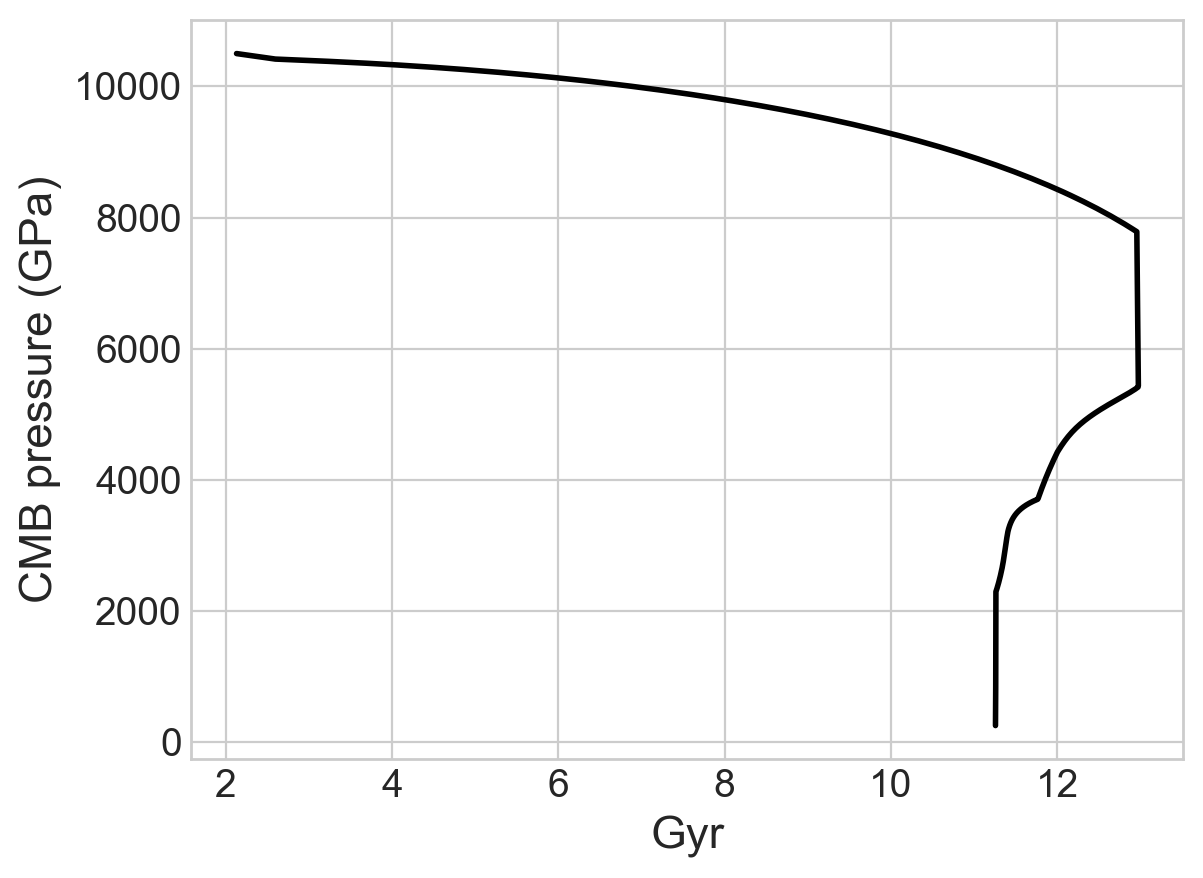

In [37]:
i_x=0
i_y=2
plt.plot(s[:,-1],s[:,i_y],color='black',linewidth=2.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('CMB pressure (GPa)',fontsize=16.5)
plt.xlabel('Gyr',fontsize=16.5) 